In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
import plotly.express as px

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
# g_palette = create_palette(8000)
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:


source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\recon")
spots_path = source_path / "out"
spots_df = pd.read_csv(spots_path / "tracked_spots.csv")
spots_df.set_index("ID", inplace=True)
save_path = spots_path
# cycle_starts = np.array([0, 30, 60, 110, 160, 280])

um_per_px = 0.525
spots_df["x"] = spots_df["POSITION_X"] * um_per_px
spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
spots_df["y"] = spots_df["POSITION_Y"] * um_per_px

pos = np.array(spots_df[["x", "y", "z"]])
pca = PCA(n_components=3)  # Choose the number of components you want to keep
transformed_data = pca.fit_transform(pos)
spots_df["AP"] = transformed_data[:, 0]
spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])

# rotation transformation puts the AP axis in the y direction:
axes = pca.components_
rotation_matrix = np.array([axes[1], axes[0], axes[2]])
pos_rot = pos @ rotation_matrix.T
spots_df["rotated_x"] = pos_rot[:, 0] - np.min(pos_rot[:, 0])
spots_df["rotated_y"] = pos_rot[:, 1] - np.min(pos_rot[:, 1])
spots_df["rotated_z"] = pos_rot[:, 2] - np.min(pos_rot[:, 2])

# mid_circle = pos_rot[(pos_rot[:, 1] < pos_rot[:, 1].mean() + 10) & (pos_rot[:, 1] > pos_rot[:, 1].mean() - 10)]
# centroid = mid_circle.mean(axis=0)
# plt.scatter(mid_circle[:, 0], mid_circle[:, 2])
# x_avg = centroid[0]
# z_avg = centroid[2]
# plt.scatter(x_avg, z_avg, c="red")
# plt.show()


spots_df["reflection_z"] = -0.2 * spots_df["rotated_z"].max() - spots_df["rotated_z"]
spots_df["reflection_x"] = spots_df["rotated_x"].max() - spots_df["rotated_x"]

spots_df["is_reflected"] = spots_df["rotated_x"] > (spots_df["rotated_x"].max() / 2 - 10)

spots_df["display_x"] = spots_df["reflection_x"] * spots_df["is_reflected"] + spots_df["rotated_x"] * (
    ~spots_df["is_reflected"])
spots_df["display_z"] = spots_df["reflection_z"] * spots_df["is_reflected"] + spots_df["rotated_z"] * (
    ~spots_df["is_reflected"])

# spots_df["reflection_z"] = 2.1 * spots_df["z"].max() - spots_df["z"]
# spots_df["reflection_x"] = spots_df["x"].max() - spots_df["x"]
# 
# spots_df["is_reflected"] = spots_df["x"] > spots_df["x"].median()
# 
# spots_df["display_x"] = spots_df["reflection_x"] * spots_df["is_reflected"] + spots_df["x"] * (
#     ~spots_df["is_reflected"])
# spots_df["display_z"] = spots_df["reflection_z"] * spots_df["is_reflected"] + spots_df["z"] * (
#     ~spots_df["is_reflected"])

spots_df["approx_time"] = spots_df["FRAME"] / 3.

t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]

best_spots["local_density"] = 0
neighborhood_um = 30
# 
# for frame in tqdm(best_spots["FRAME"].unique()):
#     frame_spots = best_spots[best_spots["FRAME"] == frame]
#     coords = frame_spots[["x", "y", "z"]].values
#     dists = cdist(coords, coords)
#     close = dists < neighborhood_um
#     local_density = close.sum(axis=1)
#     best_spots.loc[frame_spots.index, "local_density"] = local_density

In [4]:
frame = best_spots["FRAME"].max()
frame_spots = best_spots[best_spots["FRAME"] == frame].copy()
frame_spots["clone_size"] = 0

print(frame_spots.groupby("track_id")["clone_size"].count().value_counts())

clone_size
2     131
16    113
8      64
4      53
12     51
14     48
6      23
10     16
Name: count, dtype: int64


In [5]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors()

frame = best_spots["FRAME"].max()
frame_spots = best_spots[best_spots["FRAME"] == frame]

pid = np.array(frame_spots.index)
tid = np.array(frame_spots["track_id"].values)
coords = frame_spots[["x", "y", "z"]].values

knn.fit(coords)
k = 10
distances, indices = knn.kneighbors(coords, k)

pid_in = np.stack([pid]*k, -1).flatten()
tid_in = np.stack([tid]*k, -1).flatten()

pid_out = pid[np.array(indices)].flatten()
tid_out = tid[np.array(indices)].flatten()

tid_graph = nx.Graph(zip(tid_in, tid_out))
pid_graph = nx.Graph(zip(pid_in, pid_out))

In [6]:
tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))

tid_colors = nx.greedy_color(tid_graph)
# print(np.max(list(tid_colors.values())))
print(pd.Series(tid_colors.values()).value_counts() / len(tid_colors.values()))
print(pd.Series(tid_colors.values()).value_counts().index.values)

# np.save(save_path / "tid_colors")

3    0.194389
1    0.180361
4    0.178357
2    0.172345
0    0.164329
5    0.086172
6    0.020040
7    0.004008
Name: count, dtype: float64
[3 1 4 2 0 5 6 7]


In [7]:
import napari
from napari.utils.theme import available_themes, get_theme, register_theme

#palette = ["#FFCBE1", "#D6E5BD", "#F9E1A8", "#BCD8EC", "#DCCcEC", "#FFDAB4", "#444444"]
# palette = sns.color_palette("hls", 7)
palette = np.array(["#2B5356","#3D5E85","#193E55","#8DAB7F","#C0A331","#e7b5b5","#c34640","#eae0df","#444444"])
palette = np.array(["#2F3D2D","#5D653E","#2F6071","#591D1D","#A96F2D","#04253A","#AC7068","#DCC49E","#444444"])

tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))

tid_colors = nx.greedy_color(tid_graph)
# print(np.max(list(tid_colors.values())))
print(pd.Series(tid_colors.values()).value_counts() / len(tid_colors.values()))
print(pd.Series(tid_colors.values()).value_counts().index.values)

perm = list(pd.Series(tid_colors.values()).value_counts().index.values)
perm.append(len(perm))
print(perm)
palette = palette[perm]

viewer = napari.Viewer(ndisplay=3)
viewer._canvas_size = (900, 900)

# blue_theme = get_theme('dark')
# blue_theme.id = 'blue'
# blue_theme.canvas = "#0A1121"
# register_theme('blue', blue_theme, 'custom')
# viewer.theme = 'blue'

brown_theme = get_theme('dark')
brown_theme.id = 'brown'
brown_theme.canvas = "#1E1210"
register_theme('brown', brown_theme, 'custom')
viewer.theme = 'brown'

uncat = [tid for tid in best_spots["track_id"].unique() if tid not in tid_colors]
tid_colors.update({tid: -1 for tid in uncat})

print(best_spots["FRAME"].max())

sz_start = 13
sz_end = 5
f_start = 20
f_end = 268
sz = np.linspace(sz_start, sz_end, f_end - f_start + 1, endpoint=True)
# viewer = napari.Viewer(ndisplay=3)

tmppath = save_path / "napari_temp_flowers"
tmppath.mkdir(exist_ok=True)

for s, frame in tqdm(zip(sz[1:], range(f_start, f_end))):
    bs = best_spots[best_spots["FRAME"] == frame]
    tids = bs["track_id"]
    coloring = np.array([tid_colors[tid] for tid in tids])
    coloring = np.squeeze(coloring)
    color = np.array([palette[c] for c in coloring])
    color = color[coloring != -1]
    pts = np.array(bs[["display_x", "rotated_y", "display_z"]])
    pts = pts[coloring != -1]
    l = viewer.add_points(pts, name=f"frame_{frame}", border_color="#644536", border_width=0.1,
                      face_color=color, size=s, translate=[100, 0, 0], shading='none', antialiasing=0.5)
    l.refresh()
    viewer.screenshot(str(tmppath / f"frame_{frame}.png"), scale=4, flash=False)
    viewer.layers.remove(l.name)

3    0.194389
1    0.180361
4    0.178357
2    0.172345
0    0.164329
5    0.086172
6    0.020040
7    0.004008
Name: count, dtype: float64
[3 1 4 2 0 5 6 7]
[3, 1, 4, 2, 0, 5, 6, 7, 8]
268.0


248it [07:49,  1.90s/it]


In [ ]:
## 5 neighbor method

import networkx as nx
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors()

frame = best_spots["FRAME"].max()
frame_spots = best_spots[best_spots["FRAME"] == frame]

pid = np.array(frame_spots.index)
tid = np.array(frame_spots["track_id"].values)
coords = frame_spots[["x", "y", "z"]].values

knn.fit(coords)
k = 10
distances, indices = knn.kneighbors(coords, k)

pid_in = np.stack([pid] * k, -1).flatten()
tid_in = np.stack([tid] * k, -1).flatten()

pid_out = pid[np.array(indices)].flatten()
tid_out = tid[np.array(indices)].flatten()

tid_graph = nx.Graph(zip(tid_in, tid_out))
pid_graph = nx.Graph(zip(pid_in, pid_out))
tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))

tid_colors = nx.greedy_color(tid_graph)
# print(np.max(list(tid_colors.values())))
print(pd.Series(tid_colors.values()).value_counts() / len(tid_colors.values()))
print(pd.Series(tid_colors.values()).value_counts().index.values)


import napari
from napari.utils.theme import available_themes, get_theme, register_theme

#palette = ["#FFCBE1", "#D6E5BD", "#F9E1A8", "#BCD8EC", "#DCCcEC", "#FFDAB4", "#444444"]
palette = sns.color_palette("hls", 7)
# palette = np.array(["#2B5356","#3D5E85","#193E55","#8DAB7F", "#C0A331", "#e7b5b5", "#444444"])
palette = np.array(["#2B5356","#3D5E85","#193E55","#8DAB7F","#C0A331","#e7b5b5","#c34640","#eae0df","#444444"])
perm = list(pd.Series(tid_colors.values()).value_counts().index.values)
perm.append(len(perm))
palette = palette[perm]

viewer = napari.Viewer(ndisplay=3)

blue_theme = get_theme('dark')
blue_theme.id = 'blue'
blue_theme.background = 28, 31, 48  # or as tuples
blue_theme.foreground = [45, 52, 71]  # or as list
blue_theme.canvas = "#0A1121"
register_theme('blue', blue_theme, 'custom')
viewer.theme = 'blue'

uncat = [tid for tid in best_spots["track_id"].unique() if tid not in tid_colors]
tid_colors.update({tid: 6 for tid in uncat})

sz_start = 13
sz_end = 5
f_start = 20
f_end = 245
sz = np.linspace(sz_start, sz_end, f_end - f_start)
# viewer = napari.Viewer(ndisplay=3)

tmppath = save_path / "napari_temp2"
tmppath.mkdir(exist_ok=True)

for s, frame in tqdm(zip(sz, range(f_start, f_end))):
    bs = best_spots[best_spots["FRAME"] == frame]
    tids = bs["track_id"]
    coloring = [tid_colors[tid] for tid in tids]
    color = [palette[c] for c in coloring]
    l = viewer.add_points(bs[["display_x", "y", "display_z"]], name=f"frame_{frame}",
                      face_color=color, size=s, translate=[100, 0, 0])
    l.refresh()
    viewer.screenshot(str(tmppath / f"frame_{frame}.png"), scale=4, flash=False)
    viewer.layers.remove(l.name)

In [ ]:
source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon")
spots_path = source_path / "out"
spots_df = pd.read_csv(spots_path / "tracked_spots.csv")
spots_df.set_index("ID", inplace=True)
save_path = spots_path
# cycle_starts = np.array([0, 30, 60, 110, 160, 280])

um_per_px = 0.525
spots_df["x"] = spots_df["POSITION_X"] * um_per_px
spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
spots_df["y"] = spots_df["POSITION_Y"] * um_per_px

pos = np.array(spots_df[["x", "y", "z"]])
pca = PCA(n_components=3)  # Choose the number of components you want to keep
transformed_data = pca.fit_transform(pos)
spots_df["AP"] = transformed_data[:, 0]
spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])

# rotation transformation puts the AP axis in the y direction:
axes = pca.components_
rotation_matrix = np.array([axes[1], axes[0], axes[2]])
pos_rot = pos @ rotation_matrix.T
spots_df["rotated_x"] = pos_rot[:, 0] - np.min(pos_rot[:, 0])
spots_df["rotated_y"] = pos_rot[:, 1] - np.min(pos_rot[:, 1])
spots_df["rotated_z"] = pos_rot[:, 2] - np.min(pos_rot[:, 2])

spots_df["reflection_z"] = -0.2 * spots_df["rotated_z"].max() - spots_df["rotated_z"]
spots_df["reflection_x"] = spots_df["rotated_x"].max() - spots_df["rotated_x"]

spots_df["is_reflected"] = spots_df["rotated_x"] > (spots_df["rotated_x"].max() / 2 - 10)

spots_df["display_x"] = spots_df["reflection_x"] * spots_df["is_reflected"] + spots_df["rotated_x"] * (
    ~spots_df["is_reflected"])
spots_df["display_z"] = spots_df["reflection_z"] * spots_df["is_reflected"] + spots_df["rotated_z"] * (
    ~spots_df["is_reflected"])

spots_df["approx_time"] = spots_df["FRAME"] / 3.

t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]

best_spots["local_density"] = 0
neighborhood_um = 30


frame = best_spots["FRAME"].max()
frame_spots = best_spots[best_spots["FRAME"] == frame].copy()
frame_spots["clone_size"] = 0

print(frame_spots.groupby("track_id")["clone_size"].count().value_counts())

frame_spots = best_spots[best_spots["FRAME"] == frame].copy()
frame_spots["clone_size"] = 0

import networkx as nx
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors()

frame = best_spots["FRAME"].max()
frame_spots = best_spots[best_spots["FRAME"] == frame]

pid = np.array(frame_spots.index)
tid = np.array(frame_spots["track_id"].values)
coords = frame_spots[["x", "y", "z"]].values

knn.fit(coords)
k = 5
distances, indices = knn.kneighbors(coords, k)

pid_in = np.stack([pid] * k, -1).flatten()
tid_in = np.stack([tid] * k, -1).flatten()

pid_out = pid[np.array(indices)].flatten()
tid_out = tid[np.array(indices)].flatten()

tid_graph = nx.Graph(zip(tid_in, tid_out))
pid_graph = nx.Graph(zip(pid_in, pid_out))
tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))


# np.save(save_path / "tid_colors")
import napari
from napari.utils.theme import available_themes, get_theme, register_theme

# palette = np.array(["#FFCBE1", "#D6E5BD", "#F9E1A8", "#BCD8EC", "#DCCcEC", "#FFDAB4", "#444444"])
# palette = sns.color_palette("hls", 7)
bg_color = "#1E3E59"
bg_color = "#FFD285"
bg_color = "#EDD1AF"
border_color = "#10141A"
border_color = "#000000"
palette = np.array(["#F2E5D5", "#1E3E59", "#2B678C", "#D9A78B", "#DBE9D8", "#2B678C", "#444444"])

tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))

tid_colors = nx.greedy_color(tid_graph)
# print(np.max(list(tid_colors.values())))
print(pd.Series(tid_colors.values()).value_counts() / len(tid_colors.values()))
print(pd.Series(tid_colors.values()).value_counts().index.values)

perm = list(pd.Series(tid_colors.values()).value_counts().index.values)
perm.append(len(perm))
print(perm)
palette = palette[perm]

viewer = napari.Viewer(ndisplay=3)
viewer._canvas_size = (900, 900)

# blue_theme = get_theme('dark')
# blue_theme.id = 'blue'
# blue_theme.canvas = "#0A1121"
# register_theme('blue', blue_theme, 'custom')
# viewer.theme = 'blue'

brown_theme = get_theme('dark')
brown_theme.id = 'brown'
brown_theme.canvas = bg_color
register_theme('brown', brown_theme, 'custom')
viewer.theme = 'brown'

uncat = [tid for tid in best_spots["track_id"].unique() if tid not in tid_colors]
tid_colors.update({tid: -1 for tid in uncat})

print(best_spots["FRAME"].max())

sz_start = 13
sz_end = 5
f_start = 276
f_end = 278
sz = np.linspace(sz_start, sz_end, f_end - f_start + 1, endpoint=True)
# viewer = napari.Viewer(ndisplay=3)

tmppath = save_path / "napari_temp_flowers"
tmppath.mkdir(exist_ok=True)

for s, frame in tqdm(zip(sz[1:], range(f_start, f_end))):
    bs = best_spots[best_spots["FRAME"] == frame]
    tids = bs["track_id"]
    coloring = np.array([tid_colors[tid] for tid in tids])
    coloring = np.squeeze(coloring)
    color = np.array([palette[c] for c in coloring])
    color = color[coloring != -1]
    pts = np.array(bs[["display_x", "rotated_y", "display_z"]])
    pts = pts[coloring != -1]
    l = viewer.add_points(pts, name=f"frame_{frame}", border_color=border_color, border_width=0.06,
                          face_color=color, size=s, translate=[100, 0, 0], shading='none', antialiasing=0.5)
    l.refresh()
    viewer.screenshot(str(tmppath / f"frame_{frame}.png"), scale=4, flash=False)
    viewer.layers.remove(l.name)

In [57]:
source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon")
spots_path = source_path / "out"
spots_df = pd.read_csv(spots_path / "tracked_spots.csv")
spots_df.set_index("ID", inplace=True)
save_path = spots_path
# cycle_starts = np.array([0, 30, 60, 110, 160, 280])

um_per_px = 0.525
spots_df["x"] = spots_df["POSITION_X"] * um_per_px
spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
spots_df["y"] = spots_df["POSITION_Y"] * um_per_px

pos = np.array(spots_df[["x", "y", "z"]])
pca = PCA(n_components=3)  # Choose the number of components you want to keep
transformed_data = pca.fit_transform(pos)
spots_df["AP"] = transformed_data[:, 0]
spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])

# rotation transformation puts the AP axis in the y direction:
axes = pca.components_
rotation_matrix = np.array([axes[1], axes[0], axes[2]])
pos_rot = pos @ rotation_matrix.T
spots_df["rotated_x"] = pos_rot[:, 0] - np.min(pos_rot[:, 0])
spots_df["rotated_y"] = pos_rot[:, 1] - np.min(pos_rot[:, 1])
spots_df["rotated_z"] = pos_rot[:, 2] - np.min(pos_rot[:, 2])

spots_df["reflection_z"] = -0.2 * spots_df["rotated_z"].max() - spots_df["rotated_z"]
spots_df["reflection_x"] = spots_df["rotated_x"].max() - spots_df["rotated_x"]

spots_df["is_reflected"] = spots_df["rotated_x"] > (spots_df["rotated_x"].max() / 2 - 10)

spots_df["display_x"] = spots_df["reflection_x"] * spots_df["is_reflected"] + spots_df["rotated_x"] * (
    ~spots_df["is_reflected"])
spots_df["display_z"] = spots_df["reflection_z"] * spots_df["is_reflected"] + spots_df["rotated_z"] * (
    ~spots_df["is_reflected"])

spots_df["approx_time"] = spots_df["FRAME"] / 3.

t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]

best_spots["local_density"] = 0
neighborhood_um = 30

frame_spots = best_spots[best_spots["FRAME"] == frame].copy()
frame_spots["clone_size"] = 0

import networkx as nx
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors()

frame = best_spots["FRAME"].max()
frame_spots = best_spots[best_spots["FRAME"] == frame]

pid = np.array(frame_spots.index)
tid = np.array(frame_spots["track_id"].values)
coords = frame_spots[["x", "y", "z"]].values

knn.fit(coords)
k = 5
distances, indices = knn.kneighbors(coords, k)

pid_in = np.stack([pid] * k, -1).flatten()
tid_in = np.stack([tid] * k, -1).flatten()

pid_out = pid[np.array(indices)].flatten()
tid_out = tid[np.array(indices)].flatten()

tid_graph = nx.Graph(zip(tid_in, tid_out))
pid_graph = nx.Graph(zip(pid_in, pid_out))
tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))


# np.save(save_path / "tid_colors")
import napari
from napari.utils.theme import available_themes, get_theme, register_theme

colorb = "#5C78D5"
colora = "#e7b5b5"

palette = np.array(["#2B5356","#3D5E85","#193E55","#e7b5b5","#8DAB7F","#C0A331","#c34640","#eae0df","#444444"])
palette = np.array(["#2B5356","#3D5E85","#193E55","#e7b5b5","#8DAB7F","#C0A331",colorb, "#c34640","#444444"])
# palette = sns.color_palette("hls", 7)
bg_color = "#0A1121"
border_color = "#10141A"
# palette = np.array(["#F2E5D5", "#2B678C", "#1E3E59", "#D9A78B", "#DBE9D8", "#2B678C", "#444444"])

tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))

tid_colors = nx.greedy_color(tid_graph)
# print(np.max(list(tid_colors.values())))
print(pd.Series(tid_colors.values()).value_counts() / len(tid_colors.values()))
print(pd.Series(tid_colors.values()).value_counts().index.values)

perm = list(pd.Series(tid_colors.values()).value_counts().index.values)

perm.append(len(perm))
print(perm)
palette = palette[perm]


viewer = napari.Viewer(ndisplay=3)
viewer._canvas_size = (900, 900)

# blue_theme = get_theme('dark')
# blue_theme.id = 'blue'
# blue_theme.canvas = "#0A1121"
# register_theme('blue', blue_theme, 'custom')
# viewer.theme = 'blue'

brown_theme = get_theme('dark')
brown_theme.id = 'brown'
brown_theme.canvas = bg_color
register_theme('brown', brown_theme, 'custom')
viewer.theme = 'brown'

uncat = [tid for tid in best_spots["track_id"].unique() if tid not in tid_colors]
tid_colors.update({tid: -1 for tid in uncat})

for tid, c in tid_colors.items():
    if palette[c] == colora:
        if np.random.random() > 0.8:
            tid_colors[tid] = np.where(palette == colorb)[0][0]
    

print()

sz_start = 13
sz_end = 5
f_start = round(best_spots["FRAME"].max()) - 2
f_end = round(best_spots["FRAME"].max())
sz = np.linspace(sz_start, sz_end, f_end - f_start + 1, endpoint=True)
# viewer = napari.Viewer(ndisplay=3)

tmppath = save_path / "napari_temp_flowers"
tmppath.mkdir(exist_ok=True)

for s, frame in tqdm(zip(sz[1:], range(f_start, f_end))):
    bs = best_spots[best_spots["FRAME"] == frame]
    tids = bs["track_id"]
    coloring = np.array([tid_colors[tid] for tid in tids])
    coloring = np.squeeze(coloring)
    
    
    
    color = np.array([palette[c] for c in coloring])
    color = color[coloring != -1]
    
    
    pts = np.array(bs[["display_x", "rotated_y", "display_z"]])
    pts = pts[coloring != -1]
    l = viewer.add_points(pts, name=f"frame_{frame}", border_width=0.04,
                          face_color=color, size=s, translate=[100, 0, 0], shading='none', antialiasing=0.5)
    l.refresh()
    viewer.screenshot(str(tmppath / f"frame_{frame}.png"), scale=4, flash=False)
    viewer.layers.remove(l.name)

2    0.225962
3    0.225962
1    0.223558
0    0.197115
4    0.117788
5    0.009615
Name: count, dtype: float64
[2 3 1 0 4 5]
[2, 3, 1, 0, 4, 5, 6]


2it [00:03,  1.85s/it]


In [42]:
source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon")
spots_path = source_path / "out"
spots_df = pd.read_csv(spots_path / "tracked_spots.csv")
spots_df.set_index("ID", inplace=True)
save_path = spots_path
# cycle_starts = np.array([0, 30, 60, 110, 160, 280])

um_per_px = 0.525
spots_df["x"] = spots_df["POSITION_X"] * um_per_px
spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
spots_df["y"] = spots_df["POSITION_Y"] * um_per_px

pos = np.array(spots_df[["x", "y", "z"]])
pca = PCA(n_components=3)  # Choose the number of components you want to keep
transformed_data = pca.fit_transform(pos)
spots_df["AP"] = transformed_data[:, 0]
spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])

# rotation transformation puts the AP axis in the y direction:
axes = pca.components_
rotation_matrix = np.array([axes[1], axes[0], axes[2]])
pos_rot = pos @ rotation_matrix.T
spots_df["rotated_x"] = pos_rot[:, 0] - np.min(pos_rot[:, 0])
spots_df["rotated_y"] = pos_rot[:, 1] - np.min(pos_rot[:, 1])
spots_df["rotated_z"] = pos_rot[:, 2] - np.min(pos_rot[:, 2])

spots_df["reflection_z"] = -0.2 * spots_df["rotated_z"].max() - spots_df["rotated_z"]
spots_df["reflection_x"] = spots_df["rotated_x"].max() - spots_df["rotated_x"]

spots_df["is_reflected"] = spots_df["rotated_x"] > (spots_df["rotated_x"].max() / 2 - 10)

spots_df["display_x"] = spots_df["reflection_x"] * spots_df["is_reflected"] + spots_df["rotated_x"] * (
    ~spots_df["is_reflected"])
spots_df["display_z"] = spots_df["reflection_z"] * spots_df["is_reflected"] + spots_df["rotated_z"] * (
    ~spots_df["is_reflected"])

spots_df["approx_time"] = spots_df["FRAME"] / 3.

t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]

best_spots["local_density"] = 0
neighborhood_um = 30

frame_spots = best_spots[best_spots["FRAME"] == frame].copy()
frame_spots["clone_size"] = 0

import networkx as nx
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors()

frame = best_spots["FRAME"].max()
frame_spots = best_spots[best_spots["FRAME"] == frame]

pid = np.array(frame_spots.index)
tid = np.array(frame_spots["track_id"].values)
coords = frame_spots[["x", "y", "z"]].values

knn.fit(coords)
k = 5
distances, indices = knn.kneighbors(coords, k)

pid_in = np.stack([pid] * k, -1).flatten()
tid_in = np.stack([tid] * k, -1).flatten()

pid_out = pid[np.array(indices)].flatten()
tid_out = tid[np.array(indices)].flatten()

tid_graph = nx.Graph(zip(tid_in, tid_out))
pid_graph = nx.Graph(zip(pid_in, pid_out))
tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))


# np.save(save_path / "tid_colors")
import napari
from napari.utils.theme import available_themes, get_theme, register_theme

palette = np.array(["#277DA1","#90BE6D","#F94144","#F9C74F","#F8961E","#43AA8B","#444444"])
palette = np.array(["#277DA1","#90BE6D","#F94144","#F9C74F","#43AA8B","#F8961E","#444444"])
palette = np.array(sns.color_palette("hls", 7))
bg_color = "#0A1121"
bg_color = "#ffffff"
border_color = "#000000"
# palette = np.array(["#F2E5D5", "#2B678C", "#1E3E59", "#D9A78B", "#DBE9D8", "#2B678C", "#444444"])

tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))

tid_colors = nx.greedy_color(tid_graph)
# print(np.max(list(tid_colors.values())))
print(pd.Series(tid_colors.values()).value_counts() / len(tid_colors.values()))
print(pd.Series(tid_colors.values()).value_counts().index.values)

perm = list(pd.Series(tid_colors.values()).value_counts().index.values)
perm.append(len(perm))
print(perm)
palette = palette[perm]

viewer = napari.Viewer(ndisplay=3)
viewer._canvas_size = (900, 900)

# blue_theme = get_theme('dark')
# blue_theme.id = 'blue'
# blue_theme.canvas = "#0A1121"
# register_theme('blue', blue_theme, 'custom')
# viewer.theme = 'blue'

brown_theme = get_theme('dark')
brown_theme.id = 'brown'
brown_theme.canvas = bg_color
register_theme('brown', brown_theme, 'custom')
viewer.theme = 'brown'

uncat = [tid for tid in best_spots["track_id"].unique() if tid not in tid_colors]
tid_colors.update({tid: -1 for tid in uncat})

print(best_spots["FRAME"].max())

sz_start = 13
sz_end = 5
f_start = 241
f_end = 243
sz = np.linspace(sz_start, sz_end, f_end - f_start + 1, endpoint=True)
# viewer = napari.Viewer(ndisplay=3)

tmppath = save_path / "napari_rainbow_dark"
tmppath.mkdir(exist_ok=True)

for s, frame in tqdm(zip(sz[1:], range(f_start, f_end))):
    bs = best_spots[best_spots["FRAME"] == frame]
    tids = bs["track_id"]
    coloring = np.array([tid_colors[tid] for tid in tids])
    coloring = np.squeeze(coloring)
    color = np.array([palette[c] for c in coloring])
    color = color[coloring != -1]
    pts = np.array(bs[["display_x", "rotated_y", "display_z"]])
    pts = pts[coloring != -1]
    l = viewer.add_points(pts, name=f"frame_{frame}", border_color=border_color, border_width=0.04,
                          face_color=color, size=s, translate=[100, 0, 0], shading='none', antialiasing=0.5)
    l.refresh()
    viewer.screenshot(str(tmppath / f"frame_{frame}.png"), scale=4, flash=False)
    viewer.layers.remove(l.name)

2    0.225962
3    0.225962
1    0.223558
0    0.197115
4    0.117788
5    0.009615
Name: count, dtype: float64
[2 3 1 0 4 5]
[2, 3, 1, 0, 4, 5, 6]
247.0


2it [00:02,  1.42s/it]


In [30]:
import glasbey

g_palette = glasbey.create_palette(5000, lightness_bounds=(40, 90))
"2024_11_04", 
for source in ["2025_01_31", "2025_02_06"]:

    source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet") / source / "recon"
    spots_path = source_path / "out"
    spots_df = pd.read_csv(spots_path / "tracked_spots.csv")
    spots_df.set_index("ID", inplace=True)
    save_path = spots_path
    # cycle_starts = np.array([0, 30, 60, 110, 160, 280])

    um_per_px = 0.525
    spots_df["x"] = spots_df["POSITION_X"] * um_per_px
    spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
    spots_df["y"] = spots_df["POSITION_Y"] * um_per_px
    
    pos = np.array(spots_df[["x", "y", "z"]])
    pca = PCA(n_components=3)  # Choose the number of components you want to keep
    transformed_data = pca.fit_transform(pos)
    spots_df["AP"] = transformed_data[:, 0]
    spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
    
    # rotation transformation puts the AP axis in the y direction:
    axes = pca.components_
    rotation_matrix = np.array([axes[1], axes[0], axes[2]])
    pos_rot = pos @ rotation_matrix.T
    spots_df["rotated_x"] = pos_rot[:, 0] - np.min(pos_rot[:, 0])
    spots_df["rotated_y"] = pos_rot[:, 1] - np.min(pos_rot[:, 1])
    spots_df["rotated_z"] = pos_rot[:, 2] - np.min(pos_rot[:, 2])
    
    spots_df["reflection_z"] = -0.2 * spots_df["rotated_z"].max() - spots_df["rotated_z"]
    spots_df["reflection_x"] = spots_df["rotated_x"].max() - spots_df["rotated_x"]
    
    spots_df["is_reflected"] = spots_df["rotated_x"] > (spots_df["rotated_x"].max() / 2 - 10)
    
    spots_df["display_x"] = spots_df["reflection_x"] * spots_df["is_reflected"] + spots_df["rotated_x"] * (
        ~spots_df["is_reflected"])
    spots_df["display_z"] = spots_df["reflection_z"] * spots_df["is_reflected"] + spots_df["rotated_z"] * (
        ~spots_df["is_reflected"])
    
    spots_df["approx_time"] = spots_df["FRAME"] / 3.
    
    t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
    spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())
    
    best_spots = spots_df[spots_df["track_id"] > 0].copy()
    n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
    best_spots = best_spots[n_tracklets > 1]
    
    final_tids = best_spots.groupby("track_id")["FRAME"].max()[best_spots.groupby("track_id")["FRAME"].max() > best_spots["FRAME"].max() - 10].index
    print(final_tids)
    best_spots = best_spots[best_spots["track_id"].isin(final_tids)]
    
    # np.save(save_path / "tid_colors")
    import napari
    from napari.utils.theme import available_themes, get_theme, register_theme
    
    bg_color = "#000000"
    border_color = "#000000"
    # palette = np.array(["#F2E5D5", "#2B678C", "#1E3E59", "#D9A78B", "#DBE9D8", "#2B678C", "#444444"])
    
    tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
    pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))
    
    tid_colors = nx.greedy_color(tid_graph)
    # print(np.max(list(tid_colors.values())))
    print(pd.Series(tid_colors.values()).value_counts() / len(tid_colors.values()))
    print(pd.Series(tid_colors.values()).value_counts().index.values)
    
    perm = list(pd.Series(tid_colors.values()).value_counts().index.values)
    perm.append(len(perm))
    print(perm)
    palette = palette[perm]
    
    viewer = napari.Viewer(ndisplay=3)
    viewer._canvas_size = (900, 900)
    
    # blue_theme = get_theme('dark')
    # blue_theme.id = 'blue'
    # blue_theme.canvas = "#0A1121"
    # register_theme('blue', blue_theme, 'custom')
    # viewer.theme = 'blue'
    
    brown_theme = get_theme('dark')
    brown_theme.id = 'brown'
    brown_theme.canvas = bg_color
    register_theme('brown', brown_theme, 'custom')
    viewer.theme = 'brown'
    
    print(best_spots["FRAME"].max())
    
    sz_start = 13
    sz_end = 5
    f_start = round(best_spots["FRAME"].min())
    f_end = round(best_spots["FRAME"].max())
    sz = np.linspace(sz_start, sz_end, f_end - f_start + 1, endpoint=True)
    
    tids = best_spots["track_id"]
    cmap = {tid: i for i, tid in enumerate(np.unique(tids))}
    
    tmppath = save_path / "napari_glasbey"
    tmppath.mkdir(exist_ok=True)
    
    for s, frame in tqdm(zip(sz[1:], range(f_start, f_end))):
        bs = best_spots[best_spots["FRAME"] == frame]
        tids = bs["track_id"]
        
        
        color = [g_palette[cmap[tid]] for tid in tids]
        
        pts = np.array(bs[["display_x", "rotated_y", "display_z"]])

        l = viewer.add_points(pts, name=f"frame_{frame}", border_color=border_color, border_width=0.04,
                              face_color=color, size=s, translate=[100, 0, 0], shading='none', antialiasing=0.5)
        l.refresh()
        viewer.screenshot(str(tmppath / f"frame_{frame}.png"), scale=4, flash=False)
        viewer.layers.remove(l.name)

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       421, 423, 425, 426, 428, 429, 430, 431, 433, 462],
      dtype='int64', name='track_id', length=416)
2    0.225962
3    0.225962
1    0.223558
0    0.197115
4    0.117788
5    0.009615
Name: count, dtype: float64
[2 3 1 0 4 5]
[2, 3, 1, 0, 4, 5, 6]
247.0


247it [07:43,  1.87s/it]


Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       507, 508, 509, 510, 511, 512, 513, 514, 515, 516],
      dtype='int64', name='track_id', length=499)
2    0.225962
3    0.225962
1    0.223558
0    0.197115
4    0.117788
5    0.009615
Name: count, dtype: float64
[2 3 1 0 4 5]
[2, 3, 1, 0, 4, 5, 6]
268.0


266it [08:49,  1.99s/it]


Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       597, 666, 730, 757, 790, 871, 898, 899, 926, 956],
      dtype='int64', name='track_id', length=488)
2    0.225962
3    0.225962
1    0.223558
0    0.197115
4    0.117788
5    0.009615
Name: count, dtype: float64
[2 3 1 0 4 5]
[2, 3, 1, 0, 4, 5, 6]
277


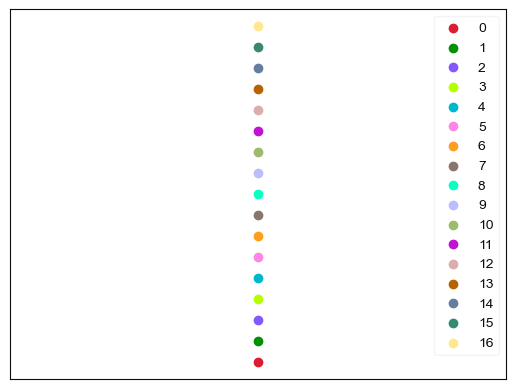

2it [00:02,  1.39s/it]


Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       421, 423, 425, 426, 428, 429, 430, 431, 433, 462],
      dtype='int64', name='track_id', length=416)
2    0.225962
3    0.225962
1    0.223558
0    0.197115
4    0.117788
5    0.009615
Name: count, dtype: float64
[2 3 1 0 4 5]
[2, 3, 1, 0, 4, 5, 6]
247.0


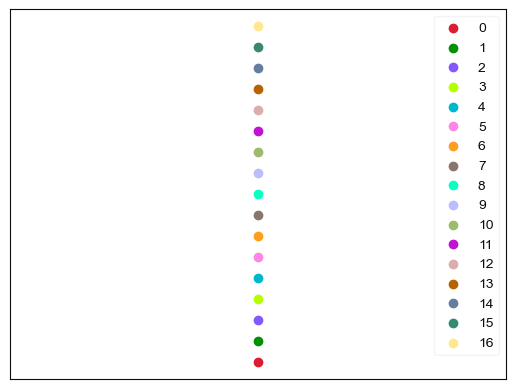

2it [00:02,  1.24s/it]


Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       507, 508, 509, 510, 511, 512, 513, 514, 515, 516],
      dtype='int64', name='track_id', length=499)
2    0.225962
3    0.225962
1    0.223558
0    0.197115
4    0.117788
5    0.009615
Name: count, dtype: float64
[2 3 1 0 4 5]
[2, 3, 1, 0, 4, 5, 6]
268.0


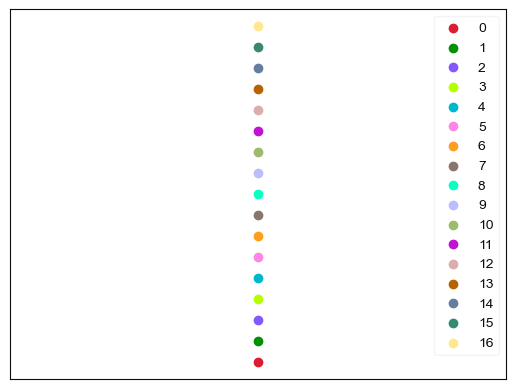

2it [00:02,  1.22s/it]


In [41]:
import glasbey

g_palette = glasbey.create_palette(5000, lightness_bounds=(40, 90))


 
for source in ["2024_11_04", "2025_01_31", "2025_02_06"]:

    source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet") / source / "recon"
    spots_path = source_path / "out"
    spots_df = pd.read_csv(spots_path / "tracked_spots.csv")
    spots_df.set_index("ID", inplace=True)
    save_path = spots_path
    

    # cycle_starts = np.array([0, 30, 60, 110, 160, 280])

    um_per_px = 0.525
    spots_df["x"] = spots_df["POSITION_X"] * um_per_px
    spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
    spots_df["y"] = spots_df["POSITION_Y"] * um_per_px
    
    pos = np.array(spots_df[["x", "y", "z"]])
    pca = PCA(n_components=3)  # Choose the number of components you want to keep
    transformed_data = pca.fit_transform(pos)
    spots_df["AP"] = transformed_data[:, 0]
    spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
    
    # rotation transformation puts the AP axis in the y direction:
    axes = pca.components_
    rotation_matrix = np.array([axes[1], axes[0], axes[2]])
    pos_rot = pos @ rotation_matrix.T
    spots_df["rotated_x"] = pos_rot[:, 0] - np.min(pos_rot[:, 0])
    spots_df["rotated_y"] = pos_rot[:, 1] - np.min(pos_rot[:, 1])
    spots_df["rotated_z"] = pos_rot[:, 2] - np.min(pos_rot[:, 2])
    
    spots_df["reflection_z"] = -0.2 * spots_df["rotated_z"].max() - spots_df["rotated_z"]
    spots_df["reflection_x"] = spots_df["rotated_x"].max() - spots_df["rotated_x"]
    
    spots_df["is_reflected"] = spots_df["rotated_x"] > (spots_df["rotated_x"].max() / 2 - 10)
    
    spots_df["display_x"] = spots_df["reflection_x"] * spots_df["is_reflected"] + spots_df["rotated_x"] * (
        ~spots_df["is_reflected"])
    spots_df["display_z"] = spots_df["reflection_z"] * spots_df["is_reflected"] + spots_df["rotated_z"] * (
        ~spots_df["is_reflected"])
    
    spots_df["approx_time"] = spots_df["FRAME"] / 3.
    
    t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
    spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())
    
    best_spots = spots_df[spots_df["track_id"] > 0].copy()
    n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
    best_spots = best_spots[n_tracklets > 1]
    
    final_tids = best_spots.groupby("track_id")["FRAME"].max()[best_spots.groupby("track_id")["FRAME"].max() > best_spots["FRAME"].max() - 10].index
    print(final_tids)
    best_spots = best_spots[best_spots["track_id"].isin(final_tids)]
    
    # np.save(save_path / "tid_colors")
    import napari
    from napari.utils.theme import available_themes, get_theme, register_theme
    
    bg_color = "#000000"
    border_color = "#000000"
    
    tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
    pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))
    
    tid_colors = nx.greedy_color(tid_graph)
    # print(np.max(list(tid_colors.values())))
    print(pd.Series(tid_colors.values()).value_counts() / len(tid_colors.values()))
    print(pd.Series(tid_colors.values()).value_counts().index.values)
    
    perm = list(pd.Series(tid_colors.values()).value_counts().index.values)
    perm.append(len(perm))
    print(perm)
    palette = palette[perm]
    
    viewer = napari.Viewer(ndisplay=3)
    viewer._canvas_size = (900, 900)
    
    brown_theme = get_theme('dark')
    brown_theme.id = 'brown'
    brown_theme.canvas = bg_color
    register_theme('brown', brown_theme, 'custom')
    viewer.theme = 'brown'
    
    print(best_spots["FRAME"].max())
    
    sz_start = 6
    sz_end = 6
    f_start = round(best_spots["FRAME"].max()-2)
    f_end = round(best_spots["FRAME"].max())
    sz = np.linspace(sz_start, sz_end, f_end - f_start + 1, endpoint=True)
    
    tids = best_spots["track_id"]
    bs = best_spots[best_spots["FRAME"] == best_spots["FRAME"].max()]
    
    cmap = {tid: i for i, tid in enumerate(np.unique(tids))}
    
    tmppath = save_path / "nclone"
    tmppath.mkdir(exist_ok=True)
    
    ax = plt.subplot()
    
    for i in np.arange(17):
        ax.scatter(0, i, c=g_palette[i], label=f"{i}")
        
    # Hide grid lines
    ax.grid(False)
    
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    plt.legend()
    plt.savefig(tmppath / "key.png")
    plt.show()
    
    for s, frame in tqdm(zip(sz[1:], range(f_start, f_end))):
        bs = best_spots[best_spots["FRAME"] == frame]
        n_clones = bs.groupby(["track_id"])["x"].count()
        
        tids = bs["track_id"]
        
        color = [g_palette[n_clones[tid]] for tid in tids]
        
        pts = np.array(bs[["display_x", "rotated_y", "display_z"]])

        l = viewer.add_points(pts, name=f"frame_{frame}", border_color=border_color, border_width=0.04,
                              face_color=color, size=s, translate=[100, 0, 0], shading='none', antialiasing=0.5)
        l.refresh()
        viewer.screenshot(str(tmppath / f"frame_{frame}.png"), scale=4, flash=False)
        viewer.layers.remove(l.name)
        


Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       597, 666, 730, 757, 790, 871, 898, 899, 926, 956],
      dtype='int64', name='track_id', length=488)
277


200it [05:49,  1.75s/it]


Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       421, 423, 425, 426, 428, 429, 430, 431, 433, 462],
      dtype='int64', name='track_id', length=416)
247.0


200it [06:00,  1.80s/it]


Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       507, 508, 509, 510, 511, 512, 513, 514, 515, 516],
      dtype='int64', name='track_id', length=499)
268.0


200it [06:02,  1.81s/it]


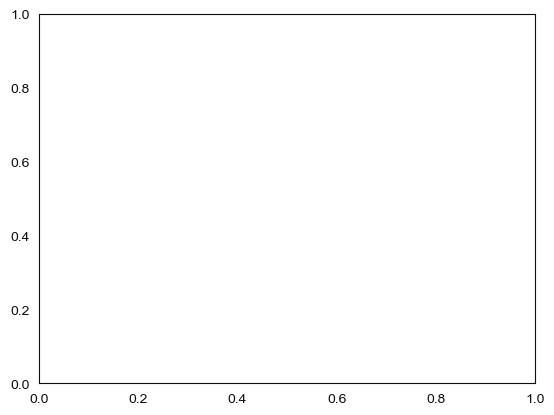

In [6]:
for source in ["2024_11_04", "2025_01_31", "2025_02_06"]:

    source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet") / source / "recon"
    spots_path = source_path / "out"
    spots_df = pd.read_csv(spots_path / "tracked_spots.csv")
    spots_df.set_index("ID", inplace=True)
    save_path = spots_path
    

    # cycle_starts = np.array([0, 30, 60, 110, 160, 280])

    um_per_px = 0.525
    spots_df["x"] = spots_df["POSITION_X"] * um_per_px
    spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
    spots_df["y"] = spots_df["POSITION_Y"] * um_per_px
    
    pos = np.array(spots_df[["x", "y", "z"]])
    pca = PCA(n_components=3)  # Choose the number of components you want to keep
    transformed_data = pca.fit_transform(pos)
    spots_df["AP"] = transformed_data[:, 0]
    spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
    
    # rotation transformation puts the AP axis in the y direction:
    axes = pca.components_
    rotation_matrix = np.array([axes[1], axes[0], axes[2]])
    pos_rot = pos @ rotation_matrix.T
    spots_df["rotated_x"] = pos_rot[:, 0] - np.min(pos_rot[:, 0])
    spots_df["rotated_y"] = pos_rot[:, 1] - np.min(pos_rot[:, 1])
    spots_df["rotated_z"] = pos_rot[:, 2] - np.min(pos_rot[:, 2])
    
    spots_df["reflection_z"] = -0.2 * spots_df["rotated_z"].max() - spots_df["rotated_z"]
    spots_df["reflection_x"] = spots_df["rotated_x"].max() - spots_df["rotated_x"]
    
    spots_df["is_reflected"] = spots_df["rotated_x"] > (spots_df["rotated_x"].max() / 2 - 10)
    
    spots_df["display_x"] = spots_df["reflection_x"] * spots_df["is_reflected"] + spots_df["rotated_x"] * (
        ~spots_df["is_reflected"])
    spots_df["display_z"] = spots_df["reflection_z"] * spots_df["is_reflected"] + spots_df["rotated_z"] * (
        ~spots_df["is_reflected"])
    
    spots_df["approx_time"] = spots_df["FRAME"] / 3.
    
    t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
    spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())
    
    best_spots = spots_df[spots_df["track_id"] > 0].copy()
    n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
    best_spots = best_spots[n_tracklets > 1]
    
    best_spots["cycle_midpt"] = best_spots["tracklet_id"].map(best_spots.groupby("tracklet_id")["FRAME"].median())
    
    final_tids = best_spots.groupby("track_id")["FRAME"].max()[best_spots.groupby("track_id")["FRAME"].max() > best_spots["FRAME"].max() - 10].index
    print(final_tids)
    best_spots = best_spots[best_spots["track_id"].isin(final_tids)]
    
    # np.save(save_path / "tid_colors")
    import napari
    from napari.utils.theme import available_themes, get_theme, register_theme
    
    bg_color = "#000000"
    border_color = "#000000"
    
    viewer = napari.Viewer(ndisplay=3)
    viewer._canvas_size = (900, 900)
    
    brown_theme = get_theme('dark')
    brown_theme.id = 'brown'
    brown_theme.canvas = bg_color
    register_theme('brown', brown_theme, 'custom')
    viewer.theme = 'brown'
    
    # tracklets = best_spots.groupby("tracklet_id")
    
    print(best_spots["FRAME"].max())
    
    sz_start = 12
    sz_end = 6
    f_start = round(best_spots["FRAME"].max()-200)
    f_end = round(best_spots["FRAME"].max())
    sz = np.linspace(sz_start, sz_end, f_end - f_start + 1, endpoint=True)
        
    tmppath = save_path / "wave_vis"
    tmppath.mkdir(exist_ok=True)
    
    ax = plt.subplot()
            
    for s, frame in tqdm(zip(sz[1:], range(f_start, f_end))):
        bs = best_spots[best_spots["FRAME"] == frame]

        color = ["yellow" if frame < mid else "blue" for mid in bs["cycle_midpt"]]
        
        pts = np.array(bs[["display_x", "rotated_y", "display_z"]])

        l = viewer.add_points(pts, name=f"frame_{frame}", border_color=border_color, border_width=0.04,
                              face_color=color, size=s, translate=[100, 0, 0], shading='none', antialiasing=0.5)
        l.refresh()
        viewer.screenshot(str(tmppath / f"frame_{frame}.png"), scale=4, flash=False)
        viewer.layers.remove(l.name)